# Membership Attack to Keras Model of MNIST Dataset

In [1]:
import tensorflow as tf
import numpy as np
import os
import dataset_loader
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

In [3]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(x_train, y_train), (x_test, y_test), (x_reserve, y_reserve) = dataset_loader.load_mnist(mnist_path)

In [4]:
print('Train samples:', len(x_train))
print('Test samples:', len(x_test))
print('Reserve Sample:', len(x_reserve))

Train samples: 50000
Test samples: 10000
Reserve Sample: 10000


Now we are going to split the data into 2 disjoints sets:
+ One to train the target model
+ The other to use as data from the same distribution to train our shadow models

In [381]:
x_target_train, x_attack_train, y_target_train, y_attack_train = train_test_split(x_train, y_train, test_size=0.5)
x_target_test, x_attack_test, y_target_test, y_attack_test = train_test_split(x_test, y_test, test_size=0.5)

print('Target Train samples:', len(x_target_train))
print('Target Test samples:', len(x_target_test))
print('Attack Train samples:', len(x_attack_train))
print('Attack Test samples:', len(x_attack_test))

Target Train samples: 25000
Target Test samples: 5000
Attack Train samples: 25000
Attack Test samples: 5000


In [382]:
x_target_train = torch.from_numpy(x_target_train).float()
y_target_train = torch.from_numpy(y_target_train).long()

x_target_test = torch.from_numpy(x_target_test).float()
y_target_test = torch.from_numpy(y_target_test).long()

### Train the target model

In [385]:
class Classifier(nn.Module):
    # the constructor, parameters are self-documented by their name :)
    # input_dim: in our case it will be the size of a single input image
    # hidden_dim: the hidden representation dim
    # output_dim: the number of class, in our case there are 10 digits
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_ratio=0.5):
        super().__init__()
        
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, batch):
        hid = self.proj1(batch)
        hid = F.relu(hid)
        hid = self.dropout(hid)
        
        return self.proj2(hid)
    

    def predict_proba(self,batch):
        prob = self.forward(batch)
        prob = torch.sigmoid(prob)
        return prob

In [386]:
n_epoch = 100
batch_size = 128
target_model = Classifier(28*28, 200, 10)

optimizer = torch.optim.Adam(target_model.parameters())

all_epoch_losses = list()
all_epoch_accuracies = list()
for epoch in range(n_epoch):
    # we keep track of the loss at each epoch
    epoch_loss = 0
    
    target_model.train() # set the network in train mode (i.e. enable dropout)
    
    # loop over the data
    for i in range(0, x_target_train.shape[0], batch_size):
        
        optimizer.zero_grad()
        batch = x_target_train[i:i+batch_size]

        logits = target_model(batch)
        #print(logits[0])
        #print(y_target_train[0])
        loss = F.cross_entropy(
            logits,
            y_target_train[i:i+batch_size],
            reduction="mean"
        )
        
        epoch_loss += loss.item() * batch.shape[0]
        
        loss.backward() # compute the gradient
        optimizer.step() # update parameters of the model
        
    # at the end of each epoch, we eval on the dev data
    target_model.eval()
    n_dev_correct = 0
    
    with torch.no_grad():
        for i in range(0, x_target_test.shape[0], batch_size):
            batch = x_target_test[i:i+batch_size]
            logits = target_model(batch)
            
            # compute the class of maximum weight for each sample,
            # look at the documentation of argmax!
            # pred shape: (n samples,)
            pred = logits.argmax(1)
            
            # compare prediction with gold classes
            n_dev_correct += (pred == y_target_test[i:i+batch_size]).sum().item()
    
    all_epoch_losses.append(epoch_loss)
    all_epoch_accuracies.append(n_dev_correct / y_target_test.shape[0]) 
    print(
        epoch, ":\t",
        epoch_loss,# / len(train_data[0]),
        "\t / dev precision:\t",
        n_dev_correct / y_target_test.shape[0],
        flush=True
    )

0 :	 14961.449994564056 	 / dev precision:	 0.9206
1 :	 6963.051434755325 	 / dev precision:	 0.94
2 :	 5320.120601654053 	 / dev precision:	 0.951
3 :	 4315.609936118126 	 / dev precision:	 0.9568
4 :	 3607.6701641082764 	 / dev precision:	 0.9626
5 :	 3072.0257781147957 	 / dev precision:	 0.9666
6 :	 2662.556899189949 	 / dev precision:	 0.9674
7 :	 2352.8966025710106 	 / dev precision:	 0.9688
8 :	 2061.4534645676613 	 / dev precision:	 0.9708
9 :	 1850.823802471161 	 / dev precision:	 0.9724
10 :	 1669.0346898138523 	 / dev precision:	 0.9718
11 :	 1462.948995679617 	 / dev precision:	 0.9722
12 :	 1287.850188717246 	 / dev precision:	 0.9724
13 :	 1158.0128458440304 	 / dev precision:	 0.974
14 :	 1056.6941581964493 	 / dev precision:	 0.9738
15 :	 968.188546076417 	 / dev precision:	 0.974
16 :	 864.2930233031511 	 / dev precision:	 0.9742
17 :	 765.0761844813824 	 / dev precision:	 0.9728
18 :	 737.971402220428 	 / dev precision:	 0.974
19 :	 644.2588673681021 	 / dev precision

In [387]:
res = target_model.predict_proba(x_target_test).detach().numpy()

In [388]:
print(res[1])

[2.3350760e-13 5.3045220e-12 7.1035950e-09 1.0000000e+00 8.5169825e-17
 2.5854537e-01 8.5350814e-21 2.5143623e-09 7.4798223e-11 5.2484854e-08]


### Train the Shadow model

In [389]:
import sys
sys.path.append('../')
from mblearn import ShadowModels

In [390]:
shadow_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

train_op = tf.optimizers.Adam(1e-4)
shadow_model.compile(optimizer=train_op,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [414]:
shm = ShadowModels(x_attack_train,
                   y_attack_train,
                   n_models=20,
                   target_classes=10,
                   learner=shadow_model,
                   epochs=100,
                   verbose=0)

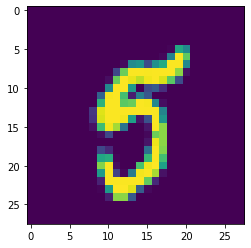

In [415]:
import matplotlib.pyplot as plt
plt.imshow(x_attack_train[0].reshape(28,28))

### Train Attack models

In [416]:
from mblearn import AttackModels
from sklearn.ensemble import RandomForestClassifier

In [417]:
rf_attack = RandomForestClassifier(n_estimators=100)

In [238]:
attacker = AttackModels(target_classes=10, attack_learner=rf_attack)

In [239]:
attacker.fit(shm.results)

### Attack for a signal class label

In [451]:
rf = RandomForestClassifier(n_estimators=5)

K = 8
class_label = shm.results[:,-2]

rf.fit(shm.results[:,:-2][class_label == K], shm.results[:,-1][class_label == K])

pr = rf.predict(shm.results[:,:-2][class_label == K])
accuracy_score(pr,shm.results[:,-1][class_label == K])

0.873109243697479

In [452]:
prr = rf.predict(X_final_test[y_final_test[0] == K])

accuracy_score(prr,Labels_test[y_final_test[0] == K])


0.6251874062968515

In [453]:
prr

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [454]:
precision_score(prr,Labels_test[y_final_test[0] == K])

0.012448132780082987

In [455]:
recall_score(prr,Labels_test[y_final_test[0] == K])

0.2

### Create attack test dataset

In [153]:
# construct a set mix up training set and attack set
# feed the set to the target model to get the predict vectors
# feed these vectors to the attack model to get the final result.

In [345]:
_, x_in_test, _, y_in_test = train_test_split(x_target_train, y_target_train, test_size=0.1)
_, x_out0_test, _, y_out0_test = train_test_split(x_attack_train, y_attack_train, test_size=0.1)
_, x_out1_test, _, y_out1_test = train_test_split(x_test, y_test, test_size=0.1)
_, x_out2_test, _, y_out2_test = train_test_split(x_reserve, y_reserve, test_size=0.1)

print('In samples:', len(x_in_test))
print('Out0 samples:', len(x_out0_test))
print('Out1 samples:', len(x_out1_test))
print('Out2 samples:', len(x_out2_test))

x_final_test = np.vstack((x_in_test, x_out0_test, x_out1_test, x_out2_test))

y_in_test = y_in_test.reshape(-1,1)
y_out0_test = y_out0_test.reshape(-1,1)
y_out1_test = y_out1_test.reshape(-1,1)
y_out2_test = y_out2_test.reshape(-1,1)

y_final_test = np.vstack((y_in_test, y_out0_test, y_out1_test, y_out2_test)).reshape(1,-1)

Labels_test = np.vstack((np.ones_like(y_in_test),np.zeros_like(y_out0_test),np.zeros_like(y_out1_test),np.zeros_like(y_out2_test)))


X_final_test = target_model.predict_proba(torch.from_numpy(x_final_test).float()).detach().numpy()

#Final_test = np.hstack((X_final_test,y_final_test))

In samples: 2500
Out0 samples: 2500
Out1 samples: 1000
Out2 samples: 1000


In [354]:
predict_prob = attacker.predict(shm.results[:,:-2],shm.results[:,-2].astype(int),batch=True)

### The shadow model's preformance?

In [337]:
result = shm.results[:,:-2]

label_results = []
for i in range(result.shape[0]):
    label_results.append(list(result[i]).index(max(result[i])))

In [338]:
label_results = np.array(label_results)

accuracy_score(label_results,shm.results[:,-2])

0.9368092263334935

In [263]:
predict = predict_prob[:,0] < predict_prob[:,1]
predict = predict.astype(int)

accuracy_score(shm.results[:,-1][:], predict[:])

0.4831091898815242

### Final Test 

In [162]:
predict_prob = attacker.predict(X_final_test,y_final_test[0],batch=True)

In [168]:
predict_prob

array([[0.55, 0.45],
       [0.48, 0.52],
       [0.48, 0.52],
       ...,
       [0.46, 0.54],
       [0.56, 0.44],
       [0.41, 0.59]])

In [164]:
predict = predict_prob[:,0] > predict_prob[:,1]
predict = predict.astype(int)

In [293]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

cross_entropy = log_loss(Labels_test, predict)
accuracy = accuracy_score(Labels_test, predict)

print('accuracy:', accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [24984, 7000]